In [1]:
import os, time
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.decomposition import PCA

import torch
from rnn_model_dt import RNN_Net

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from helpers import Arrow3D

Loaded from  ../data/neuro_perturb.pkl


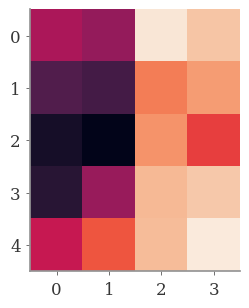

In [2]:
# Load data
file_name = "neuro_perturb.pkl"
data_file = os.path.join(data_path, file_name)
with open(data_file, 'rb') as handle:
    [
    task_names, task_lbls, n_task, lbl_sce,
    n_samples, n_sce, n_mi, dim_hid, 
    pert_dirs, pert_dir_lbls, n_pd, n_pa, pert_amp_maxs, t_pert_mins, dt_pert_intvls, dt_pert_loss, n_pt, n_mip, 
    batch_size_pert, 
    n_comp_pert, resp_lbls, n_resp, 
    loss_pre_task, loss_pert_task, 
    output_pre_task, output_pert_task, 
    noise_hid_std_ex, task_pert_task, t_perts_task,
    wo_proj_pw_task, h_pre_proj_pw_task, h_pert_proj_pw_task,
    ] = pickle.load(handle)
print('Loaded from ', data_file)

# Relative susceptibility
aucs = loss_pert_task.mean(-1).sum(-1)
rel_auc_wout_pca = aucs[..., 0] / aucs[..., 1]
plt.imshow(rel_auc_wout_pca.mean(1))

In [3]:
#############################################################################
# 1. Example aligned vs oblique
def plot_output_pert(axes):
    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        i_sce = sce_plt[i_r]
        i_s = i_s_plt[i_r]
        mi = i_s, i_sce
        i_b = i_b_plt[i_r]
        i_pa = i_pa_plt
        i_pt = i_pt_plt
        # Output
        i_out = 0
        ax.plot(ts_ex, output_pre_task[i_task][mi][i_b, :, i_out], c=colors[3], alpha=0.5, label="Unpert.")
        # i_pd = 0 # along output: 0
        for i_pd in i_pd_plt:
            mip = i_pd, i_pa, i_pt
            lbl = "Pert. " + [r"$\mathbf{w}_\mathrm{out, 1}$", r"PC$_1$"][i_pd]
            ax.plot(ts_ex, output_pert_task[i_task][mi][mip][i_b, :, i_out], ls=ls_pd[i_pd], c=cs_pd[i_pd], alpha=1, 
                    label=lbl)
            # # Target
            # m = mask_pert[i_b, :, i_out]
            # ax.plot(ts_ex[m], target_pert[i_b, :, i_out][m], 'o', ms=4, c=colors[4], alpha=0.6, label="Target")
        # Plot perturbation times
        t_perts = t_perts_task[i_task]
        ax.axvline(t_perts[i_pt], ls=':', c=c_leg, zorder=-1)
        if i_r == n_rows-1:
            ax.axvspan(t_perts.min(), t_perts.max(), 0, 0.03, color=c_leg, alpha=0.6, transform=ax.transAxes)
        ax.axhline(0, c=c_leg, zorder=-1, alpha=0.5)
        ax.set_xlim(0, t_max_plt)
        ax.set_ylim(-1.5, 5.2)
        ax.set_yticks([0, 2, 4])
        ax.set_ylabel("Output $z_1$")
        if i_r == n_rows - 1:
            ax.set_xlabel("Trial time $t$")
        else:
            ax.set_xticklabels([])
        if i_r == 0:
            ax.legend(loc=1, ncol=1, #title="Response", title_fontsize=fs,
                      labelspacing=0.1, handlelength=1.5, handletextpad=0.5, columnspacing=1.2,
                      markerscale=1., framealpha=0.9, frameon=True, 
                      bbox_to_anchor=(1.05, 1.1))

#############################################################################
# 2. Perturbation loss over pert amp.
def plot_lp(axes):
    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        i_sce = sce_plt[i_r]
        i_s = i_s_plt[i_r]
        i_pa = i_pa_plt
        i_pt = i_pt_plt
        pert_amp_max = pert_amp_maxs[task_name]
        pert_amps = np.linspace(0, pert_amp_max * np.sqrt(dim_hid), n_pa)
        x = pert_amps #/ np.sqrt(dim_hid)
        for i_pd_i in range(n_pd-2):
            # c=colors[[2, 0, 4][i_pd_i]]
            c=cs_pd[i_pd_i]
            ls = ls_pd[i_pd_i]
            lbl = pert_dir_lbls[i_pd_i]
            y = loss_pert_task[i_task, i_s, i_sce, i_pd_i].T
            plot_samples(ax, x, y, ls=ls, c=c, mode='mean_std', label=lbl, y_ge_0=True)
        # Indicate the examples on the left
        print(x[i_pa])
        ax.plot(x[i_pa], 0, 'o', c=c_leg, ms=5, clip_on=False)

        ax.set_ylim(0, 1.1)
        ax.set_yticks([0, 1])
        ax.set_xlim(x.min(), x.max())
        # ax.set_xticks([0, 5, 10])
        # lbl = "Pert. loss $L_\mathrm{pert} / L_\mathrm{rand}$"
        # lbl = "$L_\mathrm{pert}$"
        lbl = "Loss"
        ax.set_ylabel(lbl)
        if i_r == n_rows-1:
            ax.set_xlabel("Pert. amplitude")
        else:
            ax.set_xticklabels([])
    ax = axes[0, 0]
    ax.legend(loc=4, ncol=2, title="Pert. direction", title_fontsize=fs,
        labelspacing=0.2, handlelength=1.5, handletextpad=0.4, columnspacing=0.5,
        markerscale=1., framealpha=0.9, frameon=True, 
        bbox_to_anchor=(1.05, -0.03))
              # labelspacing=0.2, handlelength=1.5, handletextpad=1., columnspacing=0.6,
              # markerscale=1., framealpha=0.8, frameon=True,)
        

In [4]:
#############################################################################
# 3. Susceptibility
def plot_suscept(ax):
    ys = rel_auc_wout_pca
    xs, dxs = plot_stats(ax, ys, sce_plt, dx_fac=dx_fac)
    
    # Indicate examples on the left
    for ii_sce, i_sce in enumerate(sce_plt):
        i_s = i_s_plt[ii_sce]
        x = xs[i_task]
        dx = dxs[ii_sce]
        c = cs_sce[i_sce]
        y = rel_auc_wout_pca[i_task, i_s, i_sce]
        ax.plot(x+dx, y, 'v', c='0.2', ms=4)

    # ax.axhline(1, c=c_leg, alpha=0.5, zorder=-1)
    ax.set_ylim(0, 1.2)
    ax.set_yticks([0, 1])
    # ax.set_ylabel(r"$\mathrm{AUC}_\mathrm{out} / \mathrm{AUC}_{PC}$", loc='bottom')
    # ax.set_ylabel(r"Suscept. out$\,/\,$PC", loc='bottom')
    ax.set_ylabel(r"Rel. susceptibility", loc='bottom')
    ax.set_xticks(np.arange(n_task))
    ax.set_xticklabels(task_lbls, rotation=40, ha="right")

    if len(sce_plt) == 2:
        ax.legend(loc=1, ncol=1, 
                  # title="Initial $\mathbf{w}_\mathrm{out}$",
                  # title_fontsize=12,
                  labelspacing=0.2, handlelength=1.5, 
                  handletextpad=0.5, columnspacing=1.2,
                  markerscale=1., framealpha=0.5, frameon=True,
                  bbox_to_anchor=(1.02, 1.45))
    else:
        if leg_by_hand:
            ########################################################################
            # Legend by hand
            # Create a Rectangle patch
            if n_task == 5:
                x0 = 3.5
                dx = 1
                dxp = -1.1
                dxpp = -2.95
            else:
                x0 = 2.35
                dx = 0.8
                dxp = -0.8
                dxpp = -2.1
            x0_rec = 0.75
            dx_rec= 0.25
            y0_rec = 0.7
            dy_rec = 0.3
            y0 = 1.3
            dy = 0.15
            dyp = 0.15
            dypp = 0.15
            x1 = x0 + dx
            y1 = y0 + dy
            xis = [x0, x0, x1, x1]
            yis = [y0, y1, y0, y1]
            ypos = y1 + dyp
            rect = plt.Rectangle((x0_rec, y0_rec), dx_rec, dy_rec,
                fill=False, color=c_leg, 
                transform=fig.transFigure, figure=fig)
            fig.patches.extend([rect])
            # Points
            for i, j in np.ndindex(2, 2):
                k = 2*i + j
                x = xis[k]
                y = yis[k]
                j_c = (j+1) % 2
                i_sce = [1, 0, 3, 2][k]
                ax.plot(x, y, 'o', ms=5, c=cs_sce[i_sce], alpha=alpha_sce[i_sce], clip_on=False)
            # Text
            fs_l = 10
            ax.text(x0, ypos, r"large", va='center', ha='center', fontsize=fs_l)
            ax.text(x1, ypos, r"small", va='center', ha='center', fontsize=fs_l)
            ax.text((x0+x1)/2, ypos+dypp, "Output scale", va='center', ha='center', fontsize=fs_l)
            ax.text(x0+dxp, y1, "decaying", va='center', ha='center', fontsize=fs_l)
            ax.text(x0+dxp, y0, "chaotic", va='center', ha='center', fontsize=fs_l)
            ax.text(x0+dxpp, (y0+y1) * 0.5, "Initial\ndynamics", va='center', ha='center', fontsize=fs_l)
        else:
            for i_wo, i_sce in enumerate([2, 0]):
                # lbl = r"$\mathbf{w}_\mathrm{out}$ " + ["large", r"small"][i_wo]
                lbl = ["Aligned", "Oblique"][i_wo]
                ax.bar(0, 0, lw=0, color=cs_sce[i_sce], label=lbl)
            for i_g in range(2):
                c = ['0.7', '0.3'][i_g]
                lbl = "init. " + ["decaying", "chaotic"][i_g]
                alpha = [0.7, 1.][i_g]
                ax.bar(0, 0, lw=0, color=c, alpha=alpha, label=lbl)
            ax.legend(loc=1, ncol=1, labelspacing=0.2, handlelength=1.5, handletextpad=0.5, columnspacing=1.2,
                      markerscale=1., framealpha=0.5, frameon=False,
                      # bbox_to_anchor=(1., 1.05))
                      bbox_to_anchor=(1., 1.6))

In [5]:

# Example task
task_name = 'cycling'
i_task = np.where(np.array(task_names) == task_name)[0][0]
task_pert = task_pert_task[i_task]
ts_ex, input_ex, target_pert, mask_pert, noise_input_ex, noise_init_ex = task_pert
dim_in = input_ex.shape[-1]
dim_out = target_pert.shape[-1]
# Example regimes
sce_plt = [3, 1]
i_s_plt = [4, 0]
# i_b_plt = [2, 4]
i_b_plt = [0, 0]
# i_pa_plt = n_pa // 4
# i_pt_plt = int(n_pt // 4 * 3)
i_pa_plt = 3
i_pt_plt = 4
i_pd_plt = [0, 1]
t_max_plt = 45

leg_by_hand = True

# Colors, lines
cs_pd = colors[[3, 0, 2]]
ls_pd = ['--', (0, (3, 1, 1, 1)), ':']

/home/friedrich/code/aligned_oblique_in_rnns/notebooks/specs.py:332: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y_m, format_str, c=c, label=label, alpha=alpha_mean, **kwargs)
/home/friedrich/code/aligned_oblique_in_rnns/notebooks/specs.py:332: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y_m, format_str, c=c, label=label, alpha=alpha_mean, **kwargs)


33.941125496954285
33.941125496954285
Save figure to ../figures/neuro_perturb_summary.both


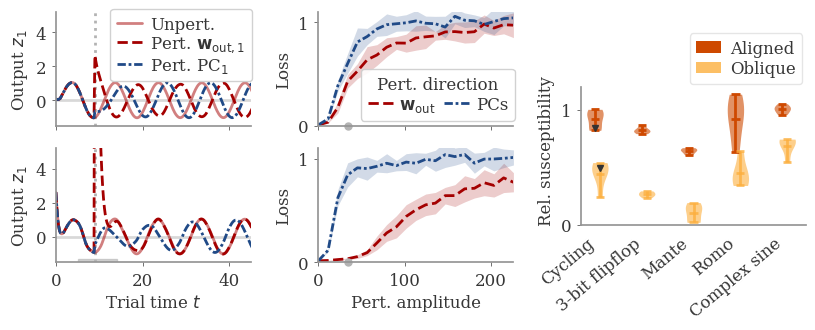

In [6]:
#####################################################################
# Join plots: 
fig = plt.figure(figsize=(7.5, 2.5), facecolor='w')
n_rows = 2
n_cols = 1
# Example
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0, right=0.26, bottom=0., top=1., wspace=0.1, hspace=0.2)
axes_ex = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
# Loss pert
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.35, right=0.61, bottom=0., top=1., wspace=0.1, hspace=0.2)
axes_lp = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
# Rel susc
gs0 = GridSpec(1, n_cols)
gs0.update(left=0.70, right=1.0, bottom=0.15, top=0.7, wspace=0.1, hspace=0.1)
axes_rs = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(1)])

plot_output_pert(axes_ex)
plot_lp(axes_lp)
dx_fac = 0.3
plot_suscept(axes_rs[0, 0])

# Save figure
fig_name = "neuro_perturb_summary"
saving_fig(fig, figure_path, fig_name, data_type='both')

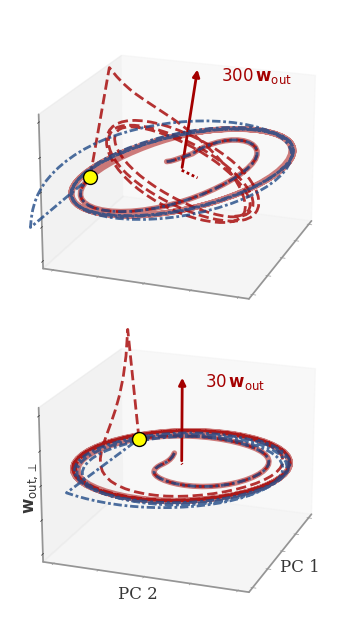

In [7]:
# Plot PCA of perturbed dynamics
def plot_pca_pert(axes_pca):
    plot_3d = True
    dim_p = 2 + plot_3d
    for i_r in range(n_rows):
        ax = axes_pca[i_r, 0]
        ii_sce = i_r
        i_sce = sce_plt[i_r]
        i_b = i_b_plt[ii_sce]
        i_s = i_s_plt[ii_sce]

        i_task = 0
        i_pa = i_pa_plt
        i_pt = i_pt_plt
        h_pre_proj = h_pre_proj_pw_task[i_task][i_s].numpy()
        h_pert_proj = h_pert_proj_pw_task[i_task][i_s].numpy()
        wo_proj = wo_proj_pw_task[i_task][i_s].numpy()
        i_t_max = int(np.argmin((ts_ex - t_max_plt)**2)) 

        # Unperturbed
        ax.plot(*h_pre_proj[i_sce, i_b, :i_t_max, :dim_p].T, c=colors[3], lw=4, alpha=0.5, label="Unpert.")
        # Perturbed
        for i_pd in i_pd_plt:
            mip = i_pd, i_pa, i_pt
            lbl = "Pert. " + [r"$\mathbf{w}_\mathrm{out}$", r"PCs"][i_pd]
            ax.plot(*h_pert_proj[i_sce][mip][i_b, :i_t_max, :dim_p].T, 
                    ls=ls_pd[i_pd], c=cs_pd[i_pd], alpha=0.8, label=lbl)
        # Point of perturbation
        t_pert = t_perts_task[i_task][i_pt]
        i_pt_ex = int(np.argmin((ts_ex - t_pert)**2)) -1
        ax.plot(*h_pre_proj[i_sce, i_b, i_pt_ex, :dim_p], 'o', c='k', ms=10, alpha=1)
        ax.plot(*h_pre_proj[i_sce, i_b, i_pt_ex, :dim_p], 'o', c='yellow', ms=8, alpha=1)

        # Output vectors
        i_out = 0
        c = colors[3]
        wop = wo_proj[i_sce, i_out] 
        w_fac_aligned = 300
        w_fac_oblique = 30
        # if out_scales[i_sce] == 'small':
        if "small" in lbl_sce[i_sce]:
            w_fac = w_fac_aligned
        else:
            w_fac = w_fac_oblique
        wop = wop * w_fac
        a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                    lw=2, arrowstyle="-|>", color=c)
        a.set_zorder(5)
        ax.add_artist(a)
        # Projection on 2d plane
        ax.plot([0, wop[0]], [0, wop[1]], [0, 0], ls=(0, (1, 1)), c=c, lw=2, alpha=1.)
        if w_fac != 1:
            y_pos = [wop[1]+5, wop[1]+5][ii_sce]
            ax.text(wop[0], y_pos, wop[2] * 0.9, 
                    r"$%d\, \mathbf{w}_\mathrm{out}$" % w_fac, color=c, fontsize=fs)
        else:
            ax.text(wop[0], wop[1]+5, wop[2] * 0.8, 
                    r"$\mathbf{w}_\mathrm{out}$", color=c, fontsize=fs)

        # Axes 
        xmax = np.abs(h_pert_proj[i_sce, ..., i_b, :, :dim_p]).max() * 0.09
        ax.set_xlim(-xmax, xmax)
        ax.set_ylim(-xmax, xmax)
        ax.set_zlim(-xmax, xmax)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        # Perspective
        ax.azim = 20
        ax.elev = 20
        if i_r == 1:
            ax.set_xlabel("PC 1", labelpad=-10)
            ax.set_ylabel("PC 2", labelpad=-12)
            ax.zaxis.set_rotate_label(False) 
            ax.set_zlabel(r"$\mathbf{w}_{\mathrm{out}, \perp}$", labelpad=-17, rotation=90)

        fixticks(ax, manage_ticks=False)
        
n_rows = len(sce_plt)
n_cols = 1
fig = plt.figure(figsize=(3.3, 6), facecolor='w')
# PCA
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1, bottom=0., top=1.1, wspace=0., hspace=-0.2)
axes_pca = np.array([[fig.add_subplot(gs0[k, j], projection='3d')
                  for j in range(n_cols)] for k in range(n_rows)])
plot_pca_pert(axes_pca)

Save figure to ../figures/fig_20_neuro_perturb_pca.both


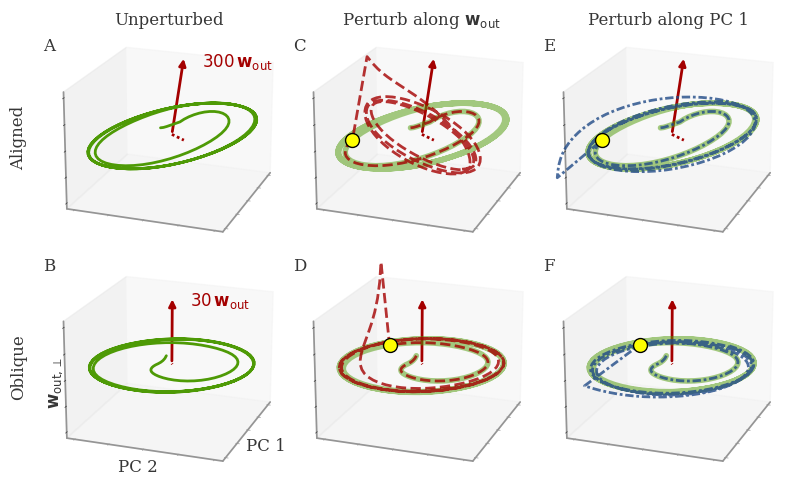

In [8]:
# Plot perturbed trajectories in PCA
n_rows = len(sce_plt)
n_cols = 3
fig = plt.figure(figsize=(2.5 * n_cols, 2.2 * n_rows), facecolor='w')
# PCA
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1, bottom=0., top=1.1, wspace=0., hspace=-0.1)
axes_pca = np.array([[fig.add_subplot(gs0[k, j], projection='3d')
                  for j in range(n_cols)] for k in range(n_rows)])

plot_3d = True
dim_p = 2 + plot_3d
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes_pca[i_r, i_c]
    ii_sce = i_r
    i_sce = sce_plt[i_r]
    i_b = i_b_plt[ii_sce]
    i_s = i_s_plt[ii_sce]
    

    i_task = 0
    i_pa = i_pa_plt
    i_pt = i_pt_plt
    h_pre_proj = h_pre_proj_pw_task[i_task][i_s].numpy()
    h_pert_proj = h_pert_proj_pw_task[i_task][i_s].numpy()
    wo_proj = wo_proj_pw_task[i_task][i_s].numpy()
    i_t_max = int(np.argmin((ts_ex - t_max_plt)**2)) 

    # Unperturbed
    if i_c == 0:
        ax.plot(*h_pre_proj[i_sce, i_b, :i_t_max, :dim_p].T, c=colors[2], label="Unpert.")
    else:
        ax.plot(*h_pre_proj[i_sce, i_b, :i_t_max, :dim_p].T, c=colors[2], lw=4, alpha=0.5, label="Unpert.")
    if i_c > 0:
        # Perturbed
        i_pd = i_c - 1
        mip = i_pd, i_pa, i_pt
        lbl = "Pert. " + [r"$\mathbf{w}_\mathrm{out}$", r"PCs"][i_pd]
        ax.plot(*h_pert_proj[i_sce][mip][i_b, :i_t_max, :dim_p].T, 
                ls=ls_pd[i_pd], c=cs_pd[i_pd], alpha=0.8, label=lbl)
    
        # Point of perturbation
        t_pert = t_perts_task[i_task][i_pt]
        i_pt_ex = int(np.argmin((ts_ex - t_pert)**2)) -1
        ax.plot(*h_pre_proj[i_sce, i_b, i_pt_ex, :dim_p], 'o', c='k', ms=10, alpha=1)
        ax.plot(*h_pre_proj[i_sce, i_b, i_pt_ex, :dim_p], 'o', c='yellow', ms=8, alpha=1)
    
    # Output vectors
    i_out = 0
    c = colors[3]
    wop = wo_proj[i_sce, i_out] 
    w_fac_aligned = 300
    w_fac_oblique = 30
    # if out_scales[i_sce] == 'small':
    if "small" in lbl_sce[i_sce]:
        w_fac = w_fac_aligned
    else:
        w_fac = w_fac_oblique
    wop = wop * w_fac
    a = Arrow3D([0, wop[0]], [0, wop[1]], [0, wop[2]], mutation_scale=10,
                lw=2, arrowstyle="-|>", color=c)
    a.set_zorder(5)
    ax.add_artist(a)
    # Projection on 2d plane
    ax.plot([0, wop[0]], [0, wop[1]], [0, 0], ls=(0, (1, 1)), c=c, lw=2, alpha=1.)
    if i_c == 0:
        if w_fac != 1:
            y_pos = [wop[1]+5, wop[1]+5][ii_sce]
            ax.text(wop[0], y_pos, wop[2] * 0.9, 
                    r"$%d\, \mathbf{w}_\mathrm{out}$" % w_fac, color=c, fontsize=fs)
        else:
            ax.text(wop[0], wop[1]+5, wop[2] * 0.8, 
                    r"$\mathbf{w}_\mathrm{out}$", color=c, fontsize=fs)

    # Axes 
    xmax = np.abs(h_pert_proj[i_sce, ..., i_b, :, :dim_p]).max() * 0.09
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-xmax, xmax)
    ax.set_zlim(-xmax, xmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # Perspective
    ax.azim = 20
    ax.elev = 20
    if i_r == 1 and i_c == 0:
        ax.set_xlabel("PC 1", labelpad=-10)
        ax.set_ylabel("PC 2", labelpad=-12)
        ax.zaxis.set_rotate_label(False) 
        ax.set_zlabel(r"$\mathbf{w}_{\mathrm{out}, \perp}$", labelpad=-17, rotation=90)
    if i_r == 0:
        lbl = ["Unperturbed", r" Perturb along $\mathbf{w}_\mathrm{out}$", r"Perturb along PC 1"][i_c]
        ax.set_title(lbl, y=1)

    fixticks(ax, manage_ticks=False)

#################################################################################
for i_r in range(n_rows):
    ax = axes_pca[i_r, 0]
    lbl = ["Aligned", "Oblique"][i_r]
    fig.text(-0.1, 0.5, lbl, fontsize=fs, va='center', ha='center', rotation=90, transform=ax.transAxes)
    
# Label plots
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes_pca[i_r, i_c]
    i = i_r + i_c * n_rows
    xpos = np.arange(0, 1, 1/n_cols)[i_c]
    dy = 1/n_rows
    ypos = (np.arange(0, 1, dy)[::-1] + dy)[i_r]
    fig.text(xpos, ypos, flbs[i], va='bottom', ha='left', fontsize=fs)

fig_name = "fig_20_neuro_perturb_pca"
saving_fig(fig, figure_path, fig_name, data_type='both')